<a href="https://colab.research.google.com/github/StratosFair/Mean_Escape_Time/blob/main/Duffin_oscillator/FEM/Duffin_Oscillator_fenics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [2]:
import fenics as fe
import mshr as msh
from matplotlib import pyplot

#  Duffing oscillator process in a ball of $\mathbb{R}^2$ : computation of solutions using Finite Element Method

Based on the paper [A neural network solution of first-passage problems](https://link.springer.com/article/10.1007/s10483-024-3189-8) (Jiamin Qian, Lincong Chen & J. Q. Sun, Oct. 2024), the 2-dimensional Duffing oscillator is defined by:
$$ d \begin{pmatrix} X_1(t)\\
X_2(t) \end{pmatrix} = \begin{pmatrix} X_2\\
-X_1 - X_1^3 - 2\zeta X_2 \end{pmatrix} dt + \begin{pmatrix} \sqrt{2\varepsilon}dB_1(t)\\
\sqrt{2\zeta} dB_2(t) \end{pmatrix}$$

The infinitesimal generator of this process is given for sufficiently smooth $f$ by
$$\mathscr Lf: x \mapsto b(x) \cdot \nabla f(x) + a(x) : \nabla^2 f(x)$$
where
$$b : x = (x_1, x_2)^T \mapsto \begin{pmatrix} x_2\\ -x_1 - x_1^3 - 2\zeta x_2 \end{pmatrix}  $$
and
$$a:x \mapsto \frac12 \sigma(x)\sigma(x)^T = \begin{pmatrix} \varepsilon & 0\\ 0 & \zeta\end{pmatrix} $$

## 1) The PDE problem

The Mean Escape Time (MET) $\tau$ is solution of the following elliptic problem

$$\begin{cases}\mathscr L\tau = -1 \quad \text{in } \Omega,\\
\tau= 0 \quad\text{ on }\partial\Omega\end{cases} $$

##2) The variational formulation

Because $\mathscr L$ is a second-order elliptic operator, we need to use integration by parts to make the PDE solvable in a traditional FEM solver. To do so, we multiply the PDE with a test function $v\in \hat V$, which belongs in the test function space $\hat V$. We then integrate over $\Omega$:
$$\begin{align*}\int_\Omega\mathscr L\tau\cdot v = -\int_\Omega v &\implies \int_\Omega \Big(x_2\partial_{x_1}\tau(x) - (x_1 + x_1^3 + 2\zeta x_2)\partial_{x_2} \tau(x) + \varepsilon \partial^2_{x_1,x_1}\tau(x) + \zeta \partial^2_{x_2,x_2}\tau(x) + 1\Big)v(x)dx = 0 \end{align*} $$

The first order derivatives of $\tau$ can be handled just fine by the solver, but the second order derivatives can't, hence we apply integration by parts to get the following weak formulation:

$$\int_\Omega \Big[\Big(x_2\partial_{x_1}\tau(x) - (x_1 + x_1^3 + 2\zeta x_2)\partial_{x_2} \tau(x)\Big)v(x) - \varepsilon \partial_{x_1}\tau(x)\partial_{x_1}v(x) - \zeta \partial_{x_2}\tau(x)\partial_{x_2}v(x)\Big] dx = - \int_\Omega v(x) dx$$

Which can be equivalently rewritten as

$$ a[\tau, v] = L(v) $$

Where $a$ is the bilinear form defined as

$$a : (\tau, v)\mapsto \int_\Omega \Big[\Big(x_2\partial_{x_1}\tau(x) - (x_1 + x_1^3 + 2\zeta x_2)\partial_{x_2} \tau(x)\Big)v(x) - \varepsilon \partial_{x_1}\tau(x)\partial_{x_1}v(x) - \zeta \partial_{x_2}\tau(x)\partial_{x_2}v(x)\Big] dx, $$

which equivalently reads

$$a : (\tau, v)\mapsto \int_\Omega \nabla\tau(x) \cdot b(x) v(x) - \text{diag}(\varepsilon, \zeta)\nabla\tau(x)\cdot\nabla v(x) dx$$

and $L$ is the linear form defined as

$$L : v\mapsto - \int_\Omega v(x) dx $$

## 3) FEniCS implementation

In [3]:
#create mesh and define function space
radius = 2
domain = msh.Circle(fe.Point(0, 0), radius)
mesh = msh.generate_mesh(domain, 128)

V = fe.FunctionSpace(mesh, "P", 3)
tau_b = fe.Constant(0.0)

def boundary(x, on_boundary):
    return on_boundary

bc = fe.DirichletBC(V, tau_b, boundary)

In [4]:
zeta = 0.08
eps = 0.001

tau = fe.TrialFunction(V)
v = fe.TestFunction(V)
f = fe.Constant(-1.0)

b = fe.Expression(("x[1]", "-x[0] - pow(x[0],3) -2*zeta *x[1]"), degree=3, zeta = zeta)
diag =  fe.Expression((("eps", 0), (0, "zeta")), degree = 0, eps=eps, zeta=zeta)

a = (fe.dot(fe.dot(fe.grad(tau),b), v) - fe.dot(fe.dot(diag, fe.grad(tau)), fe.grad(v)))*fe.dx
L = f * v * fe.dx

In [5]:
# Compute solution
tau_h = fe.Function(V)
fe.solve(a == L, tau_h, bc)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_cc8439ecd2bf4d801848ade27f420b1b2f5436fc

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_16]'
  Unique elements:           'CG3(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG3(?,?), R0(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0791643 seconds.

INFO:FFC:Compile

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_94c8ff4c2c24211b07ce143713155b1aadfb7055

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:     

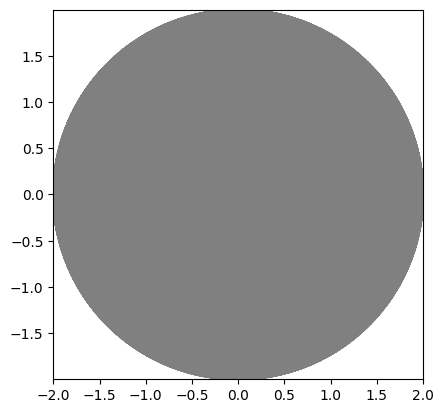

In [6]:
fe.plot(tau_h)

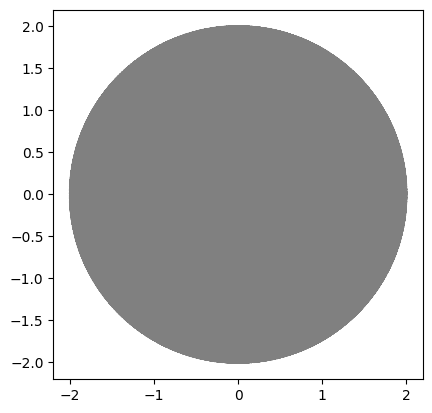

In [7]:
fe.plot(mesh)